## Random Forest Classifier:

Using a combination of governance characteristics and organizational characteristics (revenue, assets, ect.) I will predict salary using a Random Forest Classifier model.

In [82]:
import numpy as np
from numpy import random
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from numpy import interp
import joblib

## IMPORT DATA

In [3]:
# import modeling dataset
features = pd.get_dummies(pd.read_csv('02.data/model_dataset_features_eng.csv'))
X = features.drop(['reportable_comp'], axis=1)

y = pd.read_csv('02.data/target_categories_box_cox.csv', header=None, squeeze=True)

In [4]:
# verify the size of target and
# feature datasets are the same
X.shape[0] == y.shape[0]

True

## RANDOM FOREST CLASSIFIER
<a id='random_forest'></a>

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [6]:
# randomly choose 10K rows
# to parameter tune on
feature_sample = pd.concat([
    X_train,
    y_train
], axis=1).sample(n=10000)

X_train_sample = feature_sample.drop(0, axis=1)
y_train_sample = feature_sample.loc[:, 0]

In [319]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'log2'],
    'max_depth' : [4,10,20,50],
    'criterion' : ['gini', 'entropy'],
    'warm_start': [True]
}

cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3)
cv_rfc.fit(X_train_sample, y_train_sample)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=20,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=500, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='war

In [524]:
# save best parameter values
pd.DataFrame.from_dict(cv_rfc.best_params_, orient='index').to_csv('models/rfc_params.csv')

In [320]:
cv_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 500,
 'warm_start': True}

In [35]:
pd.read_csv('models/rfc_params.csv', index_col=0).squeeze()

# .to_dict()

criterion       gini
max_depth         10
max_features    auto
n_estimators     500
warm_start      True
Name: 0, dtype: object

In [60]:
# set model to best params
rfc = ensemble.RandomForestClassifier(**{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 500,
 'warm_start': True})

In [61]:
# fit model
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=True)

In [416]:
# save model
joblib.dump(rfc, 'models/rfc_model.pkl')

['models/rfc_model.pkl']

In [58]:
# load model from pickel
rfc = joblib.load('models/rfc_model.pkl')

In [38]:
# train model
rfc.score(X_train, y_train)

0.3522700162847867

In [62]:
# test model on unseen data
rfc.score(X_test, y_test)

0.2564411069161515

In [40]:
# predict categores
pred = rfc.predict(X_test)

In [420]:
# create confusion matrix and
# normalize the matrix to more accurately 
# compare which predictions the model is getting wrong
norm_conf_matrix = confusion_matrix(y_test, pred) / \
confusion_matrix(y_test, pred).sum(axis=1, keepdims=True)

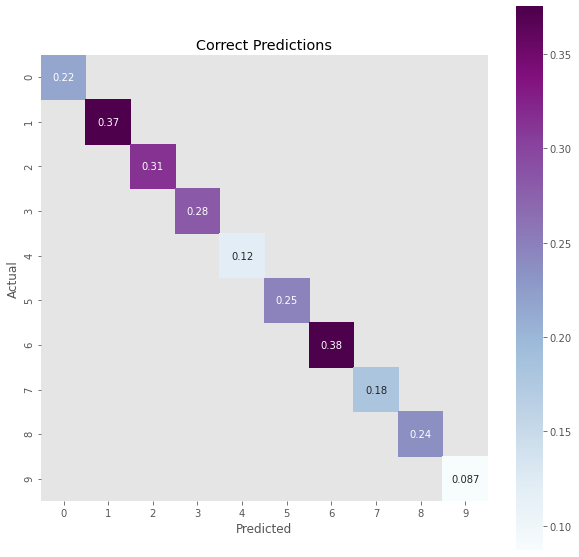

In [421]:
# display only the diagonal values
# representing values the model correctly predicted
plt.figure(figsize=(10, 10))

sns.heatmap(np.where(np.diagflat(np.diagonal(norm_conf_matrix))
            ==0, np.nan, np.diagflat(np.diagonal(norm_conf_matrix))),
            cmap='BuPu',
            annot=True,
            square=True,
            );
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Correct Predictions');

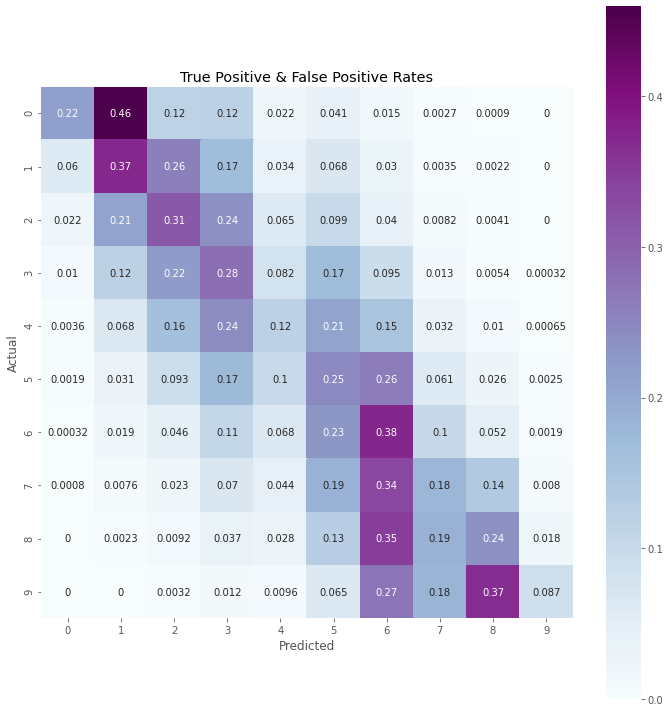

In [422]:
# compare correct and incorrect predictions
plt.figure(figsize=(10, 10))
# np.fill_diagonal(norm_conf_matrix, 0)

ax = sns.heatmap(norm_conf_matrix, 
                 square=True, annot=True, 
                 cmap='BuPu')

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('True Positive & False Positive Rates')
plt.tight_layout()
plt.savefig('03.visualizations/heat_map_rfc.png');

In [423]:
f_importances = pd.Series(rfc.feature_importances_, 
          X_train.columns).sort_values(ascending=False)

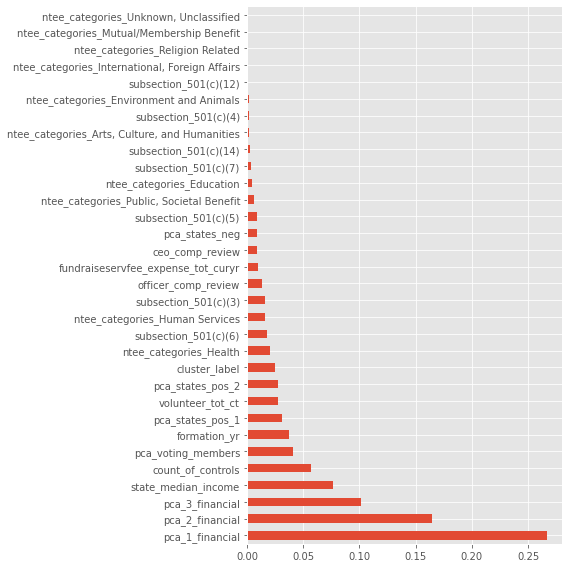

In [424]:
f_importances.plot(kind='barh', figsize=(8, 8))
plt.tight_layout()
plt.savefig('03.visualizations/rfc_feature_importance.png');

## Examining classification results 

### 1. Compare category assignment salaries against actual salaries and compute MSE(mean squared error)

In [337]:
# access median salary for each category within dictionary
pd.Series(pred).apply(lambda x: category_median_salary[x])

0        101667.5
1         85079.0
2        152129.0
3        241712.0
4        241712.0
           ...   
60251    152129.0
60252    152129.0
60253     85079.0
60254    537557.5
60255    152129.0
Length: 60256, dtype: float64

In [338]:
np.sqrt(mean_squared_error(y_test, pd.Series(pred).apply(lambda x: category_median_salary[x])))

180101.6969774165

### 2. Compare composite salaries against actual salaries and compute MSE(mean squared error)

In [41]:
# examine probability of assignment
# to specific categories
prob_pred = pd.DataFrame(rfc.predict_proba(X_test))

In [349]:
prob_pred

,0,1,2,3,4,5,6,7,8,9
0,0.113934,0.180987,0.195080,0.187980,0.128736,0.094749,0.054898,0.029505,0.011476,0.002655
1,0.184599,0.295921,0.215759,0.141973,0.078078,0.043825,0.024378,0.011022,0.003728,0.000716
2,0.001819,0.020141,0.026286,0.056999,0.079964,0.149815,0.212494,0.196717,0.171020,0.084745
3,0.055120,0.088273,0.136807,0.151623,0.169539,0.157274,0.116859,0.073354,0.038900,0.012249
4,0.272923,0.318548,0.193260,0.119485,0.051679,0.024772,0.012828,0.004165,0.002209,0.000129
...,...,...,...,...,...,...,...,...,...,...
24098,0.155373,0.230349,0.224096,0.167549,0.110130,0.061559,0.029989,0.013186,0.006708,0.001062
24099,0.002819,0.059351,0.124576,0.168127,0.157755,0.165808,0.140576,0.096513,0.064909,0.019567
24100,0.023897,0.047121,0.066365,0.087673,0.162561,0.212789,0.148353,0.124841,0.083919,0.042481
24101,0.002280,0.005518,0.011384,0.027566,0.031888,0.081223,0.145086,0.210797,0.296320,0.187939


In [350]:
# import dict with mean salary for each category
category_median_salary = pd.read_csv('02.data/category_median_salary.csv', squeeze=True).to_dict()

In [351]:
# examine dictionary to make sure it looks as it should
category_median_salary

{0: 60000.0,
 1: 72000.0,
 2: 85079.0,
 3: 101667.5,
 4: 122761.0,
 5: 152129.0,
 6: 187775.0,
 7: 241712.0,
 8: 333669.0,
 9: 537557.5}

In [352]:
# multipy each column probability by 
# the median value for that salary category
frac_salary = pd.DataFrame(prob_pred)

for column in frac_salary.columns:
    frac_salary[column] = frac_salary[column] * category_mean_salary[column]

In [353]:
frac_salary

,0,1,2,3,4,5,6,7,8,9
0,6836.066156,13031.076912,16597.214786,19111.433624,15803.755407,14414.025619,10308.492345,7131.803353,3829.136075,1426.983047
1,11075.914965,21306.319895,18356.576910,14434.083523,9584.906161,6667.055264,4577.541838,2664.263899,1244.076524,384.966197
2,109.156156,1450.127657,2236.428809,5794.955283,9816.494469,22791.214908,39900.982199,47548.753713,57064.145719,45555.193631
3,3307.208701,6355.647248,11639.415432,15415.158001,20812.829748,23925.970929,21943.190429,17730.572754,12979.849605,6584.784182
4,16375.366821,22935.464011,16442.407179,12147.791875,6344.201393,3768.508242,2408.850974,1006.850933,737.166039,69.290052
...,...,...,...,...,...,...,...,...,...,...
24098,9322.356889,16585.096843,19065.836590,17034.257060,13519.681447,9364.941400,5631.259869,3187.120147,2238.131591,571.140475
24099,169.136350,4273.304287,10598.797504,17093.001465,19366.118014,25224.158933,26396.636270,23328.233532,21658.272721,10518.365930
24100,1433.797390,3392.734788,5646.274653,8913.483545,19956.105709,32371.438709,27857.069307,30175.490648,28001.204626,22835.882616
24101,136.789770,397.271029,968.541842,2802.563508,3914.554856,12356.409599,27243.513850,50952.086555,98872.840092,101027.975307


In [354]:
np.sqrt(mean_squared_error(y_test, frac_salary.sum(axis=1)))

172653.36594441545

### 3. Compare category assignment for top two categories against actual salaries and compute MSE(mean squared error)

In [355]:
# find top two percents
top_two_prob = pd.DataFrame(prob_pred).apply(lambda x: pd.Series(x.nlargest(2)), axis=1)

In [356]:
# prorate percentages to 100% total
top_two_prob = top_two_prob.div(top_two_prob.sum(axis=1), axis=0)

In [357]:
# multiply each percent by 
# corresponding median category level
for column in top_two_prob.columns:
    top_two_prob[column] = top_two_prob[column] * category_median_salary[column]

In [358]:
np.sqrt(mean_squared_error(y_test, top_two_prob.sum(axis=1)))

220752.28615095565

### Comparison between all methods

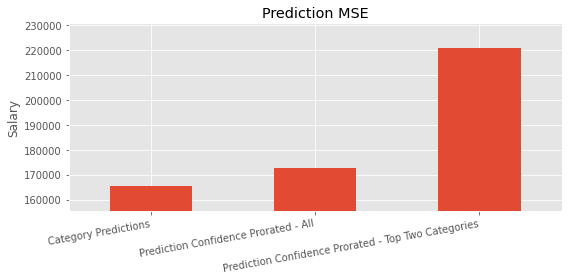

In [425]:
# combine adjustments to be able to plot
# and visualize differences between each
ax = pd.DataFrame(index=['Category Predictions',
    'Prediction Confidence Prorated - All',
    'Prediction Confidence Prorated - Top Two Categories'],
data=[np.sqrt(mean_squared_error(y_test, pd.Series(pred).apply(lambda x: category_median_salary[x]))),
np.sqrt(mean_squared_error(y_test, frac_salary.sum(axis=1))),
np.sqrt(mean_squared_error(y_test, top_two_prob.sum(axis=1)))]).plot(kind='bar',
                                                                      figsize=(8,4), 
                                                                    legend=False)

plt.ylim((pd.DataFrame(index=['Category Predictions',
    'Prediction Confidence Prorated - All',
    'Prediction Confidence Prorated - Top Two Categories'],
data=[np.sqrt(mean_squared_error(y_test, pd.Series(pred).apply(lambda x: category_median_salary[x]))),
np.sqrt(mean_squared_error(y_test, frac_salary.sum(axis=1))),
np.sqrt(mean_squared_error(y_test, top_two_prob.sum(axis=1)))]).min() - 10000).values,
         (pd.DataFrame(index=['Category Predictions',
    'Prediction Confidence Prorated - All',
    'Prediction Confidence Prorated - Top Two Categories'],
data=[np.sqrt(mean_squared_error(y_test, pd.Series(pred).apply(lambda x: category_median_salary[x]))),
np.sqrt(mean_squared_error(y_test, frac_salary.sum(axis=1))),
np.sqrt(mean_squared_error(y_test, top_two_prob.sum(axis=1)))]).max() + 10000).values)

plt.title('Prediction MSE')
plt.ylabel('Salary')
plt.xticks(rotation=10, horizontalalignment="right")

plt.tight_layout()
plt.savefig('03.visualizations/classification_adjust.png');

The difference is actually quite small, nevertheless there is some benefit to adjusting based on the probability of assignment.

### Examine distributions for each cluster based on my cluster prediction 

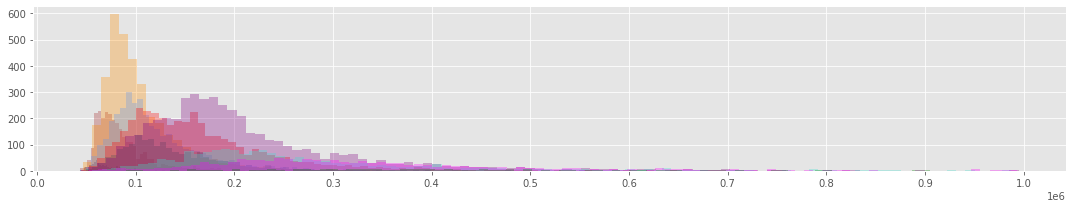

In [167]:
colors = ['navy', 
        'brown', 
        'darkorange', 
        'cornflowerblue', 
        'teal',
        'red',
       'purple',
       'turquoise',
       'magenta',
       'green']

plt.figure(figsize=(15, 3))

for i, color in enumerate(colors):
    pred_with_salary[pred_with_salary[0] == i].iloc[:,0].hist(bins=100, alpha=.3, color=color)

plt.xticks([x for x in range(0, 1100000, 100000)])
plt.tight_layout()
plt.savefig('03.visualizations/classification_hist.png');

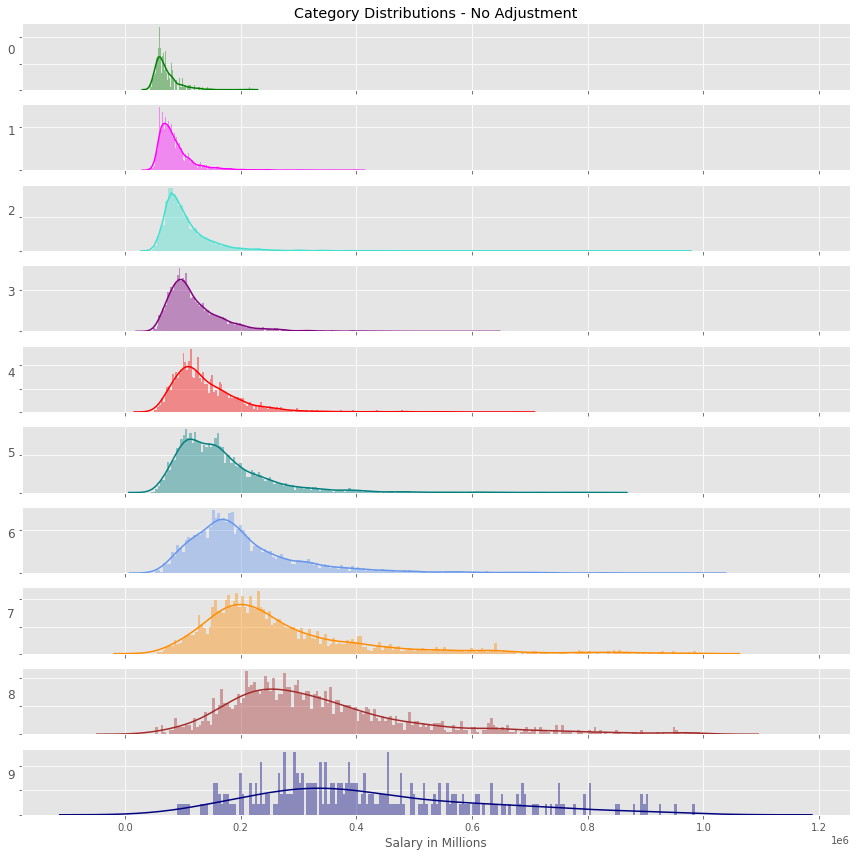

In [162]:
# plot category distributions in separate plots
# with kernel density for each category

colors = ['navy', 
        'brown', 
        'darkorange', 
        'cornflowerblue', 
        'teal',
        'red',
       'purple',
       'turquoise',
       'magenta',
       'green']

# reverse color order to correspond with 
# ordering in other areas of my presentation
colors.reverse()

fig, ax = plt.subplots(nrows=10, ncols=1, sharex=True, figsize=(12, 12))

for i, color in enumerate(colors):
    sns.distplot(pred_with_salary[pred_with_salary[0] == i].iloc[:,0],
                 bins=200,
                 color=color, ax=ax[i])
    ax[i].set_yticklabels('')
    ax[i].set_ylabel(i, rotation=0)
    ax[i].set_xlabel('')
    
ax[0].set_title('Category Distributions - No Adjustment')
ax[9].set_xlabel('Salary in Millions')

plt.tight_layout()
plt.savefig('03.visualizations/classification_hist_kde.png');

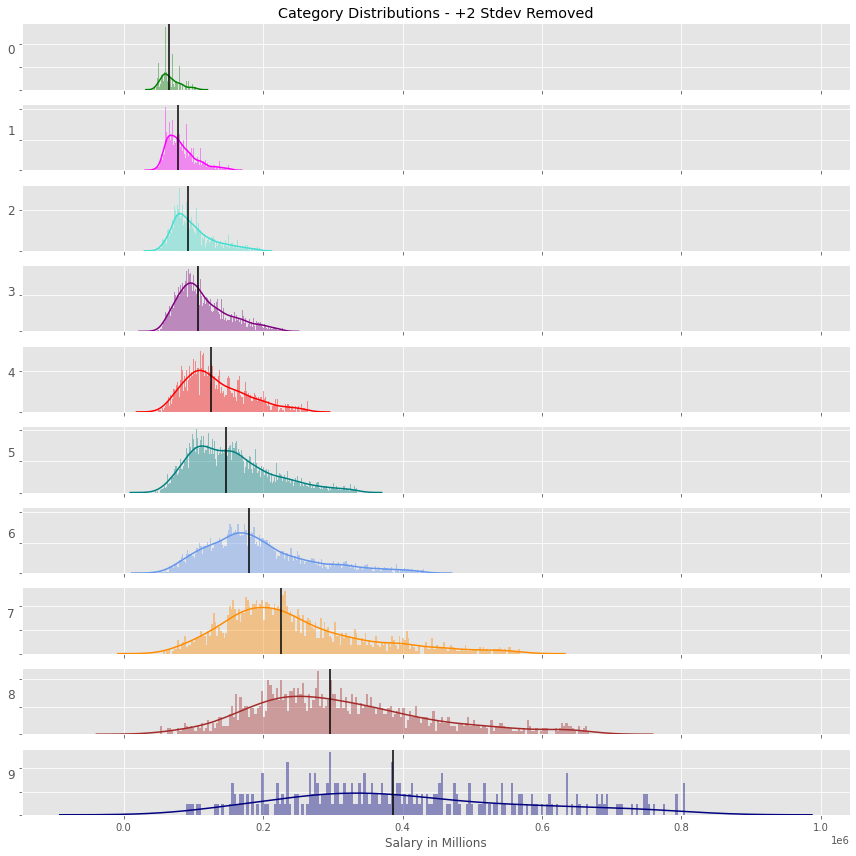

In [169]:
# plot category distributions in separate plots
# with kernel density for each category

colors = ['navy', 
        'brown', 
        'darkorange', 
        'cornflowerblue', 
        'teal',
        'red',
       'purple',
       'turquoise',
       'magenta',
       'green']

# reverse color order to correspond with 
# ordering in other areas of my presentation
colors.reverse()

fig, ax = plt.subplots(nrows=10, ncols=1, sharex=True, figsize=(12, 12))

for i, color in enumerate(colors):
    sns.distplot(pred_with_salary[pred_with_salary[0] == i].iloc[:,0] \
                 [stats.zscore(pred_with_salary[pred_with_salary[0] == i].iloc[:,0]) < 2],
                 bins=200,
                 color=color, ax=ax[i])
    ax[i].set_yticklabels('')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(i, rotation=0)

    
    ax[i].axvline(pred_with_salary[pred_with_salary[0] == i].iloc[:,0] \
                 [stats.zscore(pred_with_salary[pred_with_salary[0] == i].iloc[:,0]) < 2.5].median(), 
                  color='black')

ax[0].set_title('Category Distributions - +2 Stdev Removed')
ax[9].set_xlabel('Salary in Millions')

plt.tight_layout()
plt.savefig('03.visualizations/classification_hist_kde_median_marker.png');

### Examine the normality of the category distributions

In [44]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
# This function tests the null hypothesis that a sample comes from a normal distribution. 

for i in range(0, 10):
    t, p = stats.normaltest(pred_with_salary[pred_with_salary[0] == i].iloc[:,0])
    print('{}. - {}.'.format(t,p))

246.21924241725316. - 3.4211399459023884e-54.
1810.9576772849036. - 0.0.
3283.401555812009. - 0.0.
1919.948476638819. - 0.0.
1050.3487097942855. - 8.311427694423092e-229.
2015.3867742502016. - 0.0.
2212.285845841143. - 0.0.
649.7486509052072. - 8.107242131698688e-142.
307.72873254810537. - 1.5050632991441627e-67.
18.388455789216614. - 0.00010162429833138958.


None of these p-values are anywhere close to the .05 threshold, meaning we must reject the null hypothesis that the distribution of salary classifications for each category are normally distributed.

### Confidence Interval
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bayes_mvs.html

In [54]:
# Mean
for i in range(0, 10):
    print(i, stats.bayes_mvs(pred_with_salary[pred_with_salary[0] == i].iloc[:,0], .80)[0])

0 Mean(statistic=70316.93413173653, minmax=(69215.6851632173, 71418.18310025576))
1 Mean(statistic=87812.9017094017, minmax=(86988.27233894137, 88637.53107986203))
2 Mean(statistic=105583.08075063975, minmax=(104612.42813804632, 106553.73336323319))
3 Mean(statistic=122622.95755375593, minmax=(121482.70328718238, 123763.21182032948))
4 Mean(statistic=140350.86103687866, minmax=(138513.91032395596, 142187.81174980136))
5 Mean(statistic=167047.26683937825, minmax=(165318.14562362278, 168776.38805513372))
6 Mean(statistic=209795.82728249195, minmax=(207718.82284979426, 211872.83171518965))
7 Mean(statistic=270858.0501730104, minmax=(266219.1852894441, 275496.91505657666))
8 Mean(statistic=337240.5523520486, minmax=(331378.937026798, 343102.1676772991))
9 Mean(statistic=425701.9534883721, minmax=(409990.3271769124, 441413.5797998318))


In [51]:
# Std
for i in range(0, 10):
    print(i, stats.bayes_mvs(pred_with_salary[pred_with_salary[0] == i].iloc[:,0], .9)[2])

0 Std_dev(statistic=19237.40218185938, minmax=(18262.77467820039, 20266.7906446846))
1 Std_dev(statistic=34097.400053479236, minmax=(33348.99799685242, 34845.80211010605))
2 Std_dev(statistic=44917.32934750861, minmax=(44036.40218488572, 45798.2565101315))
3 Std_dev(statistic=53243.645223907035, minmax=(52208.79409108263, 54278.49635673144))
4 Std_dev(statistic=62000.94546537721, minmax=(60333.79930163338, 63668.091629121045))
5 Std_dev(statistic=83826.82288802184, minmax=(82257.53864908422, 85396.10712695945))
6 Std_dev(statistic=110576.0776400038, minmax=(108691.06790746632, 112461.08737254128))
7 Std_dev(statistic=150730.1682984629, minmax=(146520.11206758078, 154940.22452934503))
8 Std_dev(statistic=166050.02053133925, minmax=(160730.24279637463, 171369.79826630387))
9 Std_dev(statistic=196991.6400577481, minmax=(183207.5214554466, 211868.17467538468))


### Examine pred_probab distributions

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\mr

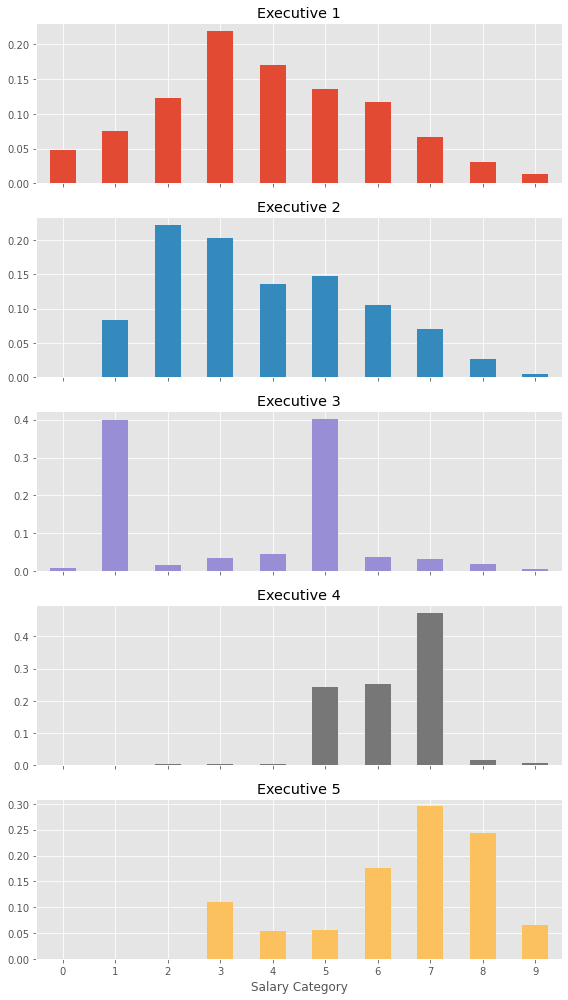

In [219]:
ax = prob_pred.iloc[0:5,:].T.rename({0: 'Executive 1',
                               1: 'Executive 2',
                               2: 'Executive 3',
                               3: 'Executive 4',
                               4: 'Executive 5',}, axis=1).plot(kind='bar', 
                             subplots=True, 
                             figsize=(8,14), 
                             sharex=True,
                            legend=False)

plt.xticks(rotation=0)
plt.xlabel('Salary Category')
plt.tight_layout()
plt.savefig('03.visualizations/pred_probaba_dist.png');

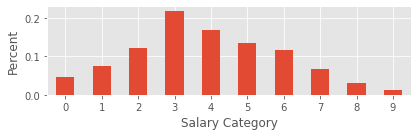

In [228]:
ax = prob_pred.iloc[0,:].plot(kind='bar', 
                             figsize=(6,2), 
                             sharex=True,
                            legend=False)
plt.xticks(rotation=0)
plt.xlabel('Salary Category')
plt.ylabel('Percent')
plt.tight_layout()
plt.savefig('03.visualizations/pred_probaba_dist_1.png');

### Examine precision/recall thresholds
https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

Precision = true positive/(true positive + false positive)

Recall = true positive/(true positive + false negative)

In [1290]:
# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=y.unique())
n_classes = Y.shape[1]

In [1239]:
Y.shape

(113851, 10)

In [1291]:
# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

In [1251]:
# Run classifier
classifier = OneVsRestClassifier(rfc)
classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)

In [1292]:
rfc.fit(X_train, Y_train)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_score = rfc.predict_proba(X_test)

In [1252]:
pd.DataFrame(y_score).head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.131566,0.000000,0.0,0.117415,0.000000,0.000000,0.000000,0.000000,0.075397,0.64131
1,0.033333,0.000000,0.0,0.000000,0.000000,0.100000,0.060000,0.183333,0.800000,0.00000
2,0.000000,0.000000,0.0,0.000000,0.345000,0.684167,0.000000,0.000000,0.000000,0.00000
3,0.000000,0.481071,0.0,0.000000,0.220635,0.259524,0.000000,0.000000,0.000000,0.00000
4,0.050000,0.000000,0.0,0.000000,0.000000,0.100000,0.027273,0.375000,0.000000,0.20000
5,0.000000,0.000000,0.0,0.800000,0.000000,0.100000,0.041667,0.000000,0.000000,0.10000
6,0.300000,0.000000,0.3,0.350000,0.100000,0.100000,0.100000,0.000000,0.000000,0.00000
7,0.100000,0.171667,0.0,0.300000,0.200000,0.200000,0.180000,0.025000,0.000000,0.00000
8,0.458333,0.000000,0.0,0.300000,0.000000,0.000000,0.000000,0.057143,0.000000,0.00000
9,0.375000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.440000,0.000000,0.00000


In [64]:
# pd.DataFrame(classifier.predict(X_test)).head(10)

Predict seems to not be making any prediction if the threshold is less than 50%.

In [1253]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.18


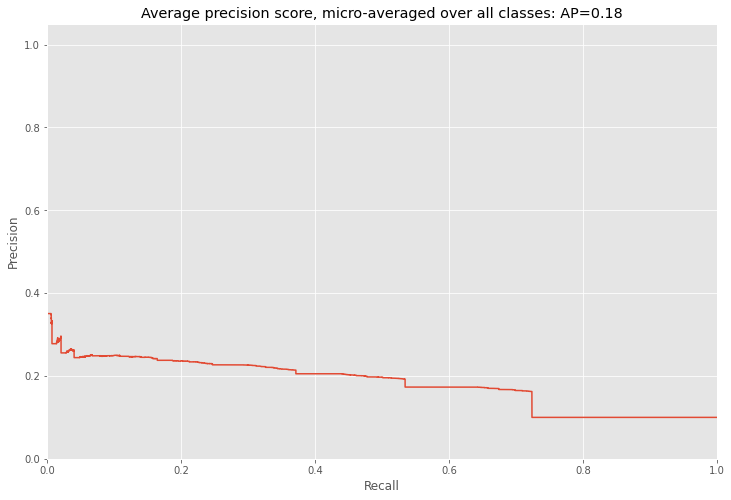

In [1254]:
plt.figure(figsize=(12, 8))
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]));

Clearly, most of the predicted labels are incorrect when compared to the training labels

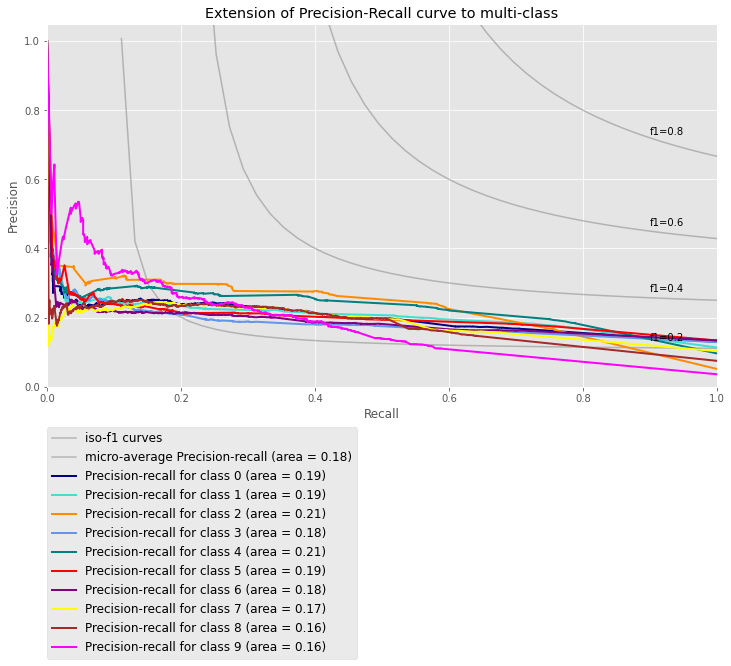

In [1255]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 
                'turquoise', 
                'darkorange', 
                'cornflowerblue', 
                'teal',
                'red',
               'purple',
               'yellow',
               'brown',
               'magenta',
               'green'])

plt.figure(figsize=(12, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.5)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
# l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.75), prop=dict(size=12))

plt.show();

### Examine ROC curve thresholds 

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

True Positive Rate(Recall) = true positive/(true positive + false negative)

False Positive Rate = false positive/(false positive + true positive)

In [1256]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

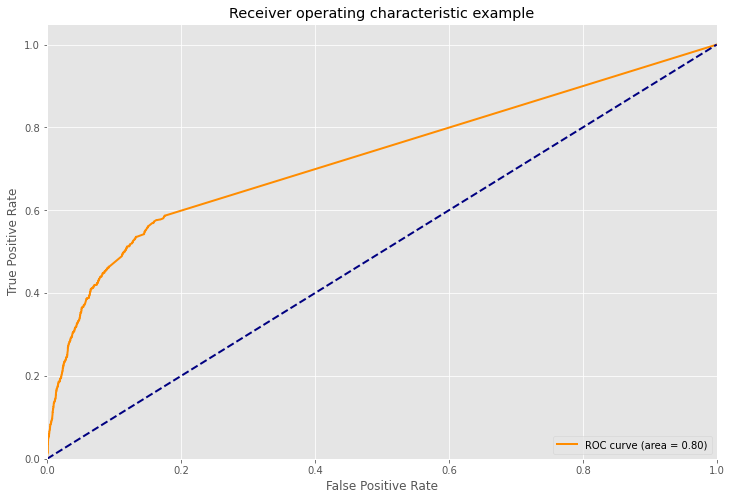

In [1257]:
# plot ROC curve for specific classes
plt.figure(figsize=(12, 8))
lw = 2
plt.plot(fpr[9], tpr[9], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

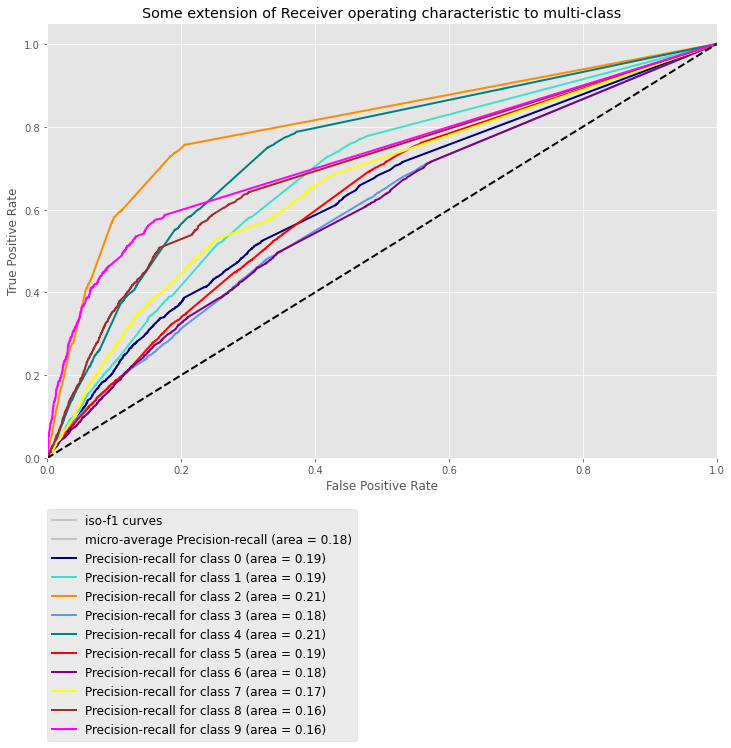

In [1258]:
# plot all classes together
lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

plt.figure(figsize=(12, 8))

colors = cycle(['navy', 
                'turquoise', 
                'darkorange', 
                'cornflowerblue', 
                'teal',
                'red',
               'purple',
               'yellow',
               'brown',
               'magenta',
               'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(lines, labels, loc=(0, -.65), prop=dict(size=12))
plt.show()

### Examine distribution of my clusters, to handle non-normal data, use kruskal parametric test

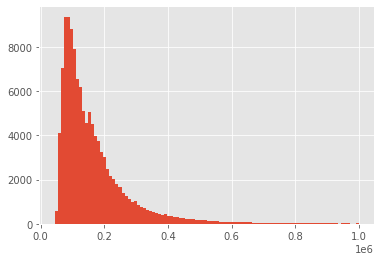

In [430]:
features.reportable_comp.hist(bins=100)

In [43]:
# join predictions with actual salaries
pred_with_salary = pd.concat([features.iloc[X_test.index].reportable_comp.reset_index(drop=True),
           pd.Series(pred)], axis=1)

In [450]:
# how many observations are in each category?
pred_with_salary.groupby(0).size()

0
0     495
1    2755
2    3369
3    4016
4    1627
5    3943
6    4696
7    1638
8    1413
9     151
dtype: int64

In [502]:
np.sort(pred_with_salary.iloc[:,1].unique())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [467]:
# examine categories 2 - 5


H, pval = stats.kruskal(pred_with_salary[pred_with_salary[0] == 4].iloc[:,0], 
                               pred_with_salary[pred_with_salary[0] == 5].iloc[:,0])
#                         pred_with_salary[pred_with_salary[0] == 2].iloc[:,0], 
#                                pred_with_salary[pred_with_salary[0] == 3].iloc[:,0])

In [468]:
H, pval

(114.01769471743344, 1.2915083274275597e-26)

In [463]:
H, pval

(226.57868378888023, 3.3227559680514766e-51)

In [459]:
H, pval

(344.4034184419677, 7.012974596060605e-77)

In [461]:
round(pval, 4)

0.0

In [ ]:
# # Kruskal-Wallace Test

# # Join all ratings together into a list, then ranking them.
# ranks = stats.rankdata(
#     roller_coasters['Europe'].tolist() +
#     roller_coasters['LatinAmerica'].tolist() +
#     roller_coasters['NorthAmerica'].tolist())

# # Add the new ranked variables to the data frame.
# roller_coasters['Ranks_Europe'] = ranks[0:20]
# roller_coasters['Ranks_LatinAmerica'] = ranks[20:40]
# roller_coasters['Ranks_NorthAmerica'] = ranks[40:60]

# # Average rank per group.
# groups = ['Ranks_Europe', 'Ranks_LatinAmerica', 'Ranks_NorthAmerica']
# print(roller_coasters[groups].apply(np.mean))

# # Overall average rank.
# print(np.mean(ranks))

# # Print the test statistic followed by the probability of getting this result
# # if the groups were not different.
# stats.kruskal(
#     roller_coasters['Europe'],
#     roller_coasters['LatinAmerica'],
#     roller_coasters['NorthAmerica'])